In [1]:
import warnings
warnings.filterwarnings('ignore')
from keras.models import Sequential
import keras
import tensorflow as tf
from keras import backend as K
warnings.filterwarnings('ignore')
import pandas as pd
from pylab import *
%matplotlib inline

Using TensorFlow backend.


# 1. Training

In [3]:
trainset= pd.read_pickle('../data/pickle/dataset_IMAGE_train.pkl')

In [77]:
cmapdict = {0:"Blues",1:"Reds",2:"Greens",3:"Purples"}
titledict = {0:"Electron",1:"Photon",2:"Muon",3:"Pion+"}
for i in range(100):
    label = trainset.loc[i].label
    im = np.array(trainset.loc[i].feature)
    
    plt.figure(figsize=(6,2),facecolor='w')
    
    plt.imshow(im[:,:,2].T,cmap=cmapdict[label],vmin=0)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel("layer")
    plt.ylabel("cluster")
    plt.title(titledict[label])
    plt.axvspan(28,49, color='k',alpha=0.1,linewidth=0)
    plt.axvspan(40,49, color='k',alpha=0.1,linewidth=0)
    plt.xlim(0,49)
    
    plt.savefig("../plots/{}.png".format(i),dpi=200)
    plt.close()

In [75]:
# load data
x_train,y_train = [],[]
for i in range(len(trainset)):
    temp = trainset.loc[i].feature
    temp = np.array(temp).reshape(50, 10, 3)
    x_train.append(temp)
    
    l = trainset.loc[i].label
    temp = np.zeros(4)
    temp[l] = 1
    y_train.append(temp)
    
x_train = np.array(x_train)
y_train = np.array(y_train)

# load model
from keras.layers import Dense,Conv1D,Conv2D,Flatten,Input
from keras import Model
def shower_classification_model():
    input_img = Input(shape=(50, 10, 3), name='input')
    conv = Conv2D(3, (5,1), activation='relu', padding='same', data_format='channels_last', name='conv1')(input_img)
    conv = Conv2D(3, (3,3), activation='relu', padding='same', data_format='channels_last', name='conv2')(conv)
    conv = Conv2D(3, (3,3), activation='relu', padding='same', data_format='channels_last', name='conv3')(conv)
    flat = Flatten()(conv)
    dense1 = Dense(128, activation='relu', name='dense1')(flat)
    dense2 = Dense(32 , activation='relu', name='dense2')(dense1)
    pred = Dense(4, activation='softmax' , name='output')(dense2)
    model = Model(inputs=input_img, outputs=pred)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model = shower_classification_model()

Instructions for updating:
Colocations handled automatically by placer.


In [76]:
# train
model.fit(x_train, y_train, epochs=8, batch_size=100, validation_split=0.1)

Instructions for updating:
Use tf.cast instead.
Train on 25200 samples, validate on 2800 samples
Epoch 1/8
25200/25200 [==============================] - 11s 454us/step - loss: 0.4441 - acc: 0.7680 - val_loss: 0.3711 - val_acc: 0.7939
Epoch 2/8
25200/25200 [==============================] - 9s 338us/step - loss: 0.3661 - acc: 0.7917 - val_loss: 0.3632 - val_acc: 0.8007
Epoch 3/8
25200/25200 [==============================] - 9s 357us/step - loss: 0.3567 - acc: 0.7969 - val_loss: 0.3648 - val_acc: 0.8039
Epoch 4/8
25200/25200 [==============================] - 8s 337us/step - loss: 0.3484 - acc: 0.8033 - val_loss: 0.3624 - val_acc: 0.8089
Epoch 5/8
25200/25200 [==============================] - 8s 334us/step - loss: 0.3397 - acc: 0.8092 - val_loss: 0.3666 - val_acc: 0.7986
Epoch 6/8
25200/25200 [==============================] - 11s 422us/step - loss: 0.3332 - acc: 0.8130 - val_loss: 0.3636 - val_acc: 0.8039
Epoch 7/8
25200/25200 [==============================] - 9s 373us/step - loss: 

In [78]:
# save model
def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ""
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph
    
frozen_graph = freeze_session(K.get_session(),
                              output_names=[out.op.name for out in model.outputs])

tf.train.write_graph(frozen_graph, "../models/", "CNN.pb", as_text=False)
tf.train.write_graph(frozen_graph, "../models/", "CNN.pbtxt", as_text=True)

Instructions for updating:
Use tf.compat.v1.graph_util.convert_variables_to_constants
Instructions for updating:
Use tf.compat.v1.graph_util.extract_sub_graph
INFO:tensorflow:Froze 53 variables.
INFO:tensorflow:Converted 53 variables to const ops.


'../models/CNN.pbtxt'

# Confuse Matrix

In [79]:
whichset = "test"

testset = pd.read_pickle('../data/pickle/dataset_IMAGE_{}.pkl'.format(whichset))

x,y = [],[]
for i in range(len(testset)):
    temp = testset.loc[i].feature
    temp = np.array(temp).reshape(50, 10, 3)
    x.append(temp)
    
    temp = testset.loc[i].label
    y.append(temp)
    
inputs = np.array(x)
labels = np.array(y)
predicts = model.predict(inputs)
predicts = np.argmax(predicts, axis=1)
print(predicts.shape)

(12000,)


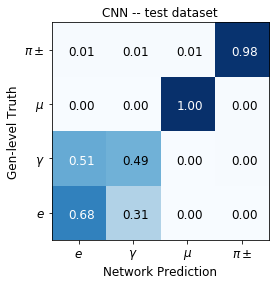

In [80]:
# a) plot confusion matrix
%matplotlib inline
h = np.histogram2d(labels,predicts,bins=np.arange(5))[0]
hnorm = h.copy()
for i in range(h.shape[0]):
    hnorm[i] /= h[i].sum()
plt.figure(facecolor='w')
plt.imshow(hnorm,origin='lower',cmap="Blues")
plt.ylabel('Gen-level Truth',fontsize=12)
plt.xlabel('Network Prediction',fontsize=12)
plt.yticks(np.arange(4),[r'$e$',r'$\gamma$',r'$\mu$',r'$\pi\pm$'],fontsize=12)
plt.xticks(np.arange(4),[r'$e$',r'$\gamma$',r'$\mu$',r'$\pi\pm$'],fontsize=12)


for i in range(4):
    for j in range(4):
        clr = 'k'
        val = hnorm[j,i]
        if val >0.5:
            clr = 'w'
        plt.text(i-0.2,j-0.1,'{:4.2f}'.format(val), color=clr,fontsize=12)
plt.title('CNN -- {} dataset'.format(whichset))
plt.savefig('../plots/TICLNet/{}_confusion_CNN.png'.format(whichset),dpi=200)

In [4]:
x_train,y_train,pid_train = [],[],[]
for i in range(len(trainset)): 
    temp = trainset.loc[i].feature
    temp = np.array(temp).reshape(50, 10, 3)
    x_train.append(np.sum(temp[:,:,2]))
    y_train.append(trainset.loc[i].gen_energy)
    pid_train.append(trainset.loc[i].label)
x_train,y_train,pid_train = np.array(x_train),np.array(y_train),np.array(pid_train)

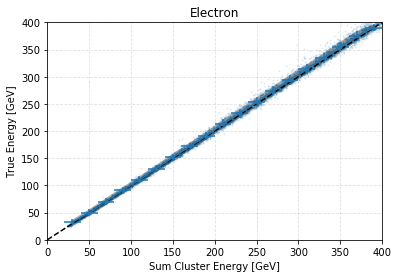

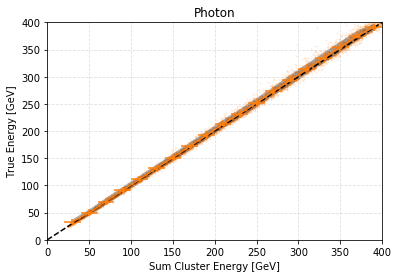

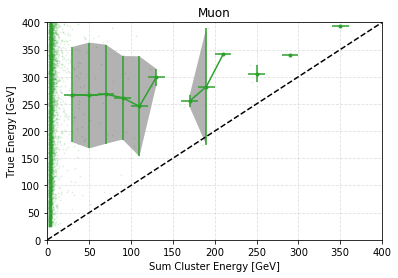

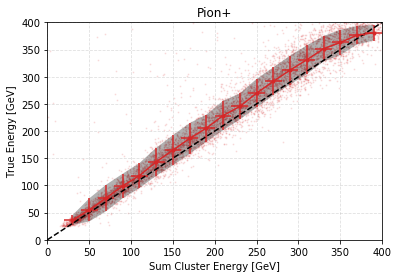

In [45]:
cdict = {0:"C0",1:"C1",2:"C2",3:"C3"}
titledict = {0:"Electron",1:"Photon",2:"Muon",3:"Pion+"}

for i in range(4):
    plt.figure(facecolor='w',figsize=[6,4])
    slt = pid_train==i
    plt.scatter(x_train[slt],y_train[slt],c=cdict[i],alpha=0.1,s=1)
    plt.title(titledict[i])
    plt.grid(True,linestyle="--",alpha=0.4)
    plt.ylabel("True Energy [GeV]")
    plt.xlabel("Sum Cluster Energy [GeV]")
    plt.plot([0,400],[0,400],'k--')
    plt.xlim(0,400)
    plt.ylim(0,400)
    
    bins = np.arange(20,401,20)
    center = bins[:-1]+20/2
    h,_ = np.histogram(x_train[slt],bins,weights=y_train[slt] )
    h2,_ = np.histogram(x_train[slt],bins,weights=y_train[slt]**2 )
    n,_ = np.histogram(x_train[slt],bins )
    mean,std = h/n,np.sqrt(h2/n - (h/n)**2)
    plt.errorbar(center,mean,yerr=std,xerr=10,fmt='.-',color=cdict[i])
    plt.fill_between(center,mean+std,mean-std,lw=0,facecolor="k",alpha=0.3)

    plt.savefig("{}.png".format(titledict[i]),dpi=300)



<Container object of 3 artists>

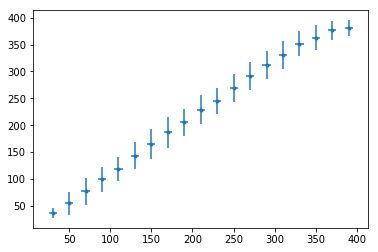

In [18]:
center

array([ 25.,  35.,  45.,  55.,  65.,  75.,  85.,  95., 105., 115., 125.,
       135., 145., 155., 165., 175., 185., 195., 205., 215., 225., 235.,
       245., 255., 265., 275., 285., 295., 305., 315., 325., 335., 345.,
       355., 365., 375., 385., 395.])

In [19]:
mean

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1.])